# Project PBMC onto PBMC68K
## Xiaonan Wang
## 27Oct2017

In [1]:
%config InlineBackend.figure_formats = ['retina']  # increase resolution on retina screens
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import scanpy.api as sc
from matplotlib.colors import LinearSegmentedColormap
import sys
sys.path.append('/servers/lila-single-cell/Xiaonan/python_modules/')
from TenX_sub import *

cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.verbosity = 0                # increase for more output
sc.settings.set_dpi(80)                  # low pixel number yields small inline figures
sc.logging.print_version_and_date()

/home/USSR/xw251/anaconda2/envs/mypython3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Running Scanpy version 0.2.3 on 2018-05-11 13:51.


## Read in Data

In [2]:
%%time
PBMC_data = sc.read("PBMC_corrected_all_hvg.txt", cache=True, delimiter="\t")

CPU times: user 10.6 s, sys: 516 ms, total: 11.1 s
Wall time: 12 s


# Make prediction based on 68K PBMC data

## Make prediciton on PBMC data

In [4]:
filename_data = '/servers/lila-single-cell/Xiaonan/TenX_68K_data/filtered_matrices_mex/hg19/matrix.mtx'
filename_genes = '/servers/lila-single-cell/Xiaonan/TenX_68K_data/filtered_matrices_mex/hg19/genes.tsv'
filename_barcodes = '/servers/lila-single-cell/Xiaonan/TenX_68K_data/filtered_matrices_mex/hg19/barcodes.tsv'

In [5]:
%%time
adata = sc.read(filename_data, cache=True).transpose()
adata.var_names = np.genfromtxt(filename_genes, dtype=str)[:, 1]
adata.var['Ensembl'] = np.genfromtxt(filename_genes, dtype=str)[:, 0]
adata.smp_names = np.genfromtxt(filename_barcodes, dtype=str)
sc.logging.print_memory_usage()

Memory usage: current 0.65 GB, difference +0.65 GB
CPU times: user 2.57 s, sys: 412 ms, total: 2.98 s
Wall time: 3.2 s


In [6]:
mito_genes = np.array([name for name in adata.var_names if name.startswith('MT-')])
# for each cell compute fraction of counts in mito genes vs. all genes
adata.smp['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.smp['n_counts'] = np.sum(adata.X, axis=1).A1

In [7]:
%%time
sc.pp.filter_genes(adata, min_counts=1)  # only consider genes with more than 1 count
sc.pp.normalize_per_cell(adata)          # normalize with total UMI count per cell

CPU times: user 1.78 s, sys: 260 ms, total: 2.04 s
Wall time: 2.03 s


In [8]:
hvg_incommon = np.intersect1d(adata.var['Ensembl'], PBMC_data.var['Ensembl'])

In [9]:
print(len(hvg_incommon))

1576


In [10]:
adata_index = [np.where(adata.var['Ensembl']==x)[0][0] for x in hvg_incommon]

In [11]:
adata = adata[:, adata_index] 

In [46]:
%%time
sc.pp.log1p(adata)
adata = sc.pp.regress_out(adata, ['n_counts', 'percent_mito'], copy=True)
sc.pp.scale(adata)
sc.logging.print_memory_usage()


Memory usage: current 1.40 GB, difference +0.61 GB
CPU times: user 22min 19s, sys: 6.83 s, total: 22min 25s
Wall time: 22min 24s


In [47]:
sc.write('PBMC_68K', adata)

### Get same HVG set for PBMC data

In [12]:
PNMC_index = [np.where(PBMC_data.var['Ensembl']==x)[0][0] for x in hvg_incommon]

In [13]:
PBMC_data_new = PBMC_data[:,PNMC_index]

### Combine data and save it

In [56]:
from scipy.sparse import csr_matrix

save files for scmap analysis

In [59]:
%%time
np.savetxt("PBMC_PBMC68k_combined.txt", np.concatenate((PBMC_data_new.X, adata.X), axis=0))

CPU times: user 2min 52s, sys: 6.03 s, total: 2min 58s
Wall time: 3min 3s


### Now can import and start classification

In [60]:
%%time
All_data = sc.read("PBMC_PBMC68k_combined.txt", cache=True)

CPU times: user 2min 5s, sys: 5.08 s, total: 2min 10s
Wall time: 2min 11s


In [61]:
%%time
sc.tl.tsne(All_data,n_jobs=40)
sc.logging.print_memory_usage()

Memory usage: current 4.71 GB, difference +0.73 GB
CPU times: user 1h 21min 27s, sys: 1h 34min 35s, total: 2h 56min 3s
Wall time: 9min 16s


In [62]:
D = sc.utils.comp_distance(All_data.smp['X_pca'], metric='euclidean')

In [64]:
print(D.shape+PBMC_data_new.X.shape+adata.X.shape)

(85698, 85698, 17119, 1576, 68579, 1576)


In [65]:
D_sub = D[0:17119, 17119:85698]

In [17]:
filename_labels = '/servers/lila-single-cell/Xiaonan/TenX_68K_data/filtered_matrices_mex/hg19/PBMC68k.cellLables.txt'
bulk_labels = np.genfromtxt(filename_labels, delimiter='\t', dtype=str)
adata.smp['bulk_labels'] = bulk_labels[:adata.n_smps]

In [68]:
from collections import Counter
cl_assigned = []
for i in range(D_sub.shape[0]):
    CellDis = D_sub[i,:]
    CellDis_sorted = np.argsort(CellDis)[:15]
    max_samples = adata.smp['bulk_labels'][CellDis_sorted]
    most_cl = Counter(max_samples)
    #print(most_cl)
    if len(ct) == 1:
            cl_assigned.append(ct[0][0])
    else:
            ct1 = ct[0]
            ct2 = ct[1]
            if (ct1[1] == ct2[1]):
                cl_assigned.append('Unknown')
            else:
                cl_assigned.append(ct1[0])
cl_assigned = np.stack(cl_assigned)

In [75]:
class_df = []
for i in np.unique(adata.smp['bulk_labels']):
    print(i)
    assigned_ratio = sum(cl_assigned==i)*100/len(cl_assigned)
    real_ratio = sum(adata.smp['bulk_labels']==i)*100/len(adata.smp['bulk_labels'])
    class_df.append([assigned_ratio, real_ratio])
class_df = pd.DataFrame(class_df, columns=['Predicted', 'Expected'], index=np.unique(adata.smp['bulk_labels']))

CD14+ Monocyte
CD19+ B
CD34+
CD4+ T Helper2
CD4+/CD25 T Reg
CD4+/CD45RA+/CD25- Naive T
CD4+/CD45RO+ Memory
CD56+ NK
CD8+ Cytotoxic T
CD8+/CD45RA+ Naive Cytotoxic
Dendritic


In [79]:
class_df

,Predicted,Expected
CD14+ Monocyte,2.167183,4.820718
CD19+ B,14.632864,5.565844
CD34+,0.105146,0.382041
CD4+ T Helper2,0.000000,0.027705
CD4+/CD25 T Reg,21.233717,20.577728
CD4+/CD45RA+/CD25- Naive T,0.105146,4.072675
CD4+/CD45RO+ Memory,0.864536,4.558247
CD56+ NK,7.774987,8.543432
CD8+ Cytotoxic T,11.367486,16.688782
CD8+/CD45RA+ Naive Cytotoxic,41.597056,32.043337


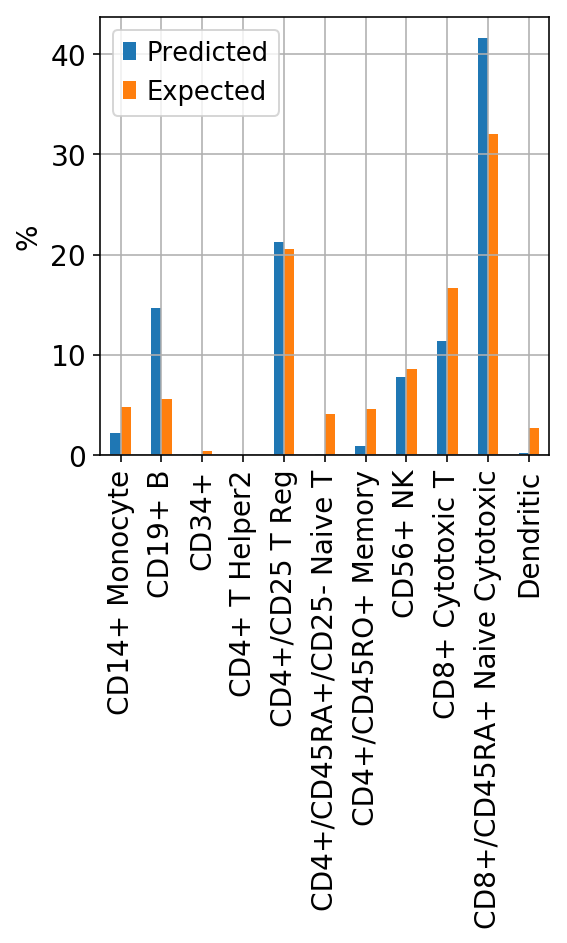

In [78]:
plt.figure(figsize=(20,8))
ax = class_df.plot(kind='bar')
ax.set_ylabel("%")

In [80]:
PBMC_data.smp['Classification_68K'] = cl_assigned

    CD14+ Monocyte   CD19+ B     CD34+  CD4+/CD25 T Reg  \
D1        0.063749  0.151630  0.001080         0.206195   
D2        0.001829  0.111222  0.001330         0.227764   
D3        0.001081  0.179067  0.000721         0.201765   

    CD4+/CD45RA+/CD25- Naive T  CD4+/CD45RO+ Memory  CD56+ NK  \
D1                    0.001080             0.009724  0.052944   
D2                    0.001496             0.008313  0.093101   
D3                    0.000540             0.007926  0.085930   

    CD8+ Cytotoxic T  CD8+/CD45RA+ Naive Cytotoxic  Dendritic  
D1          0.073654                      0.435800   0.004142  
D2          0.124522                      0.430258   0.000166  
D3          0.141956                      0.380652   0.000360  


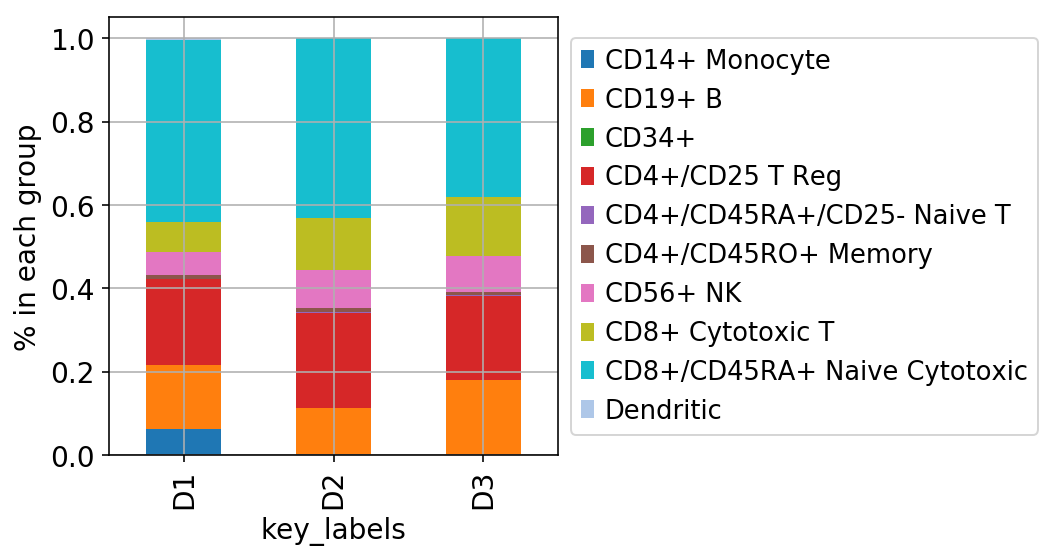

In [83]:
lv_stat_barplot(PBMC_data, rgroup='Classification_68K', cgroup='key_labels')

   CD14+ Monocyte   CD19+ B     CD34+  CD4+/CD25 T Reg  \
0        0.000000  0.000834  0.000000         0.087549   
1        0.000336  0.828687  0.000672         0.038965   
2        0.000688  0.002409  0.000688         0.509291   
3        0.000000  0.000000  0.000426         0.202046   
4        0.000000  0.000000  0.000000         0.039100   
5        0.000000  0.002157  0.003595         0.757009   
6        0.000735  0.000000  0.005882         0.007353   
7        0.811947  0.006637  0.000000         0.011062   
8        0.000000  0.184211  0.000000         0.508772   
9        0.000000  0.009259  0.000000         0.472222   

   CD4+/CD45RA+/CD25- Naive T  CD4+/CD45RO+ Memory  CD56+ NK  \
0                    0.002223             0.001946  0.000000   
1                    0.000000             0.000336  0.001008   
2                    0.000688             0.035788  0.002065   
3                    0.000426             0.012788  0.040068   
4                    0.002142            

,CD14+ Monocyte,CD19+ B,CD34+,CD4+/CD25 T Reg,CD4+/CD45RA+/CD25- Naive T,CD4+/CD45RO+ Memory,CD56+ NK,CD8+ Cytotoxic T,CD8+/CD45RA+ Naive Cytotoxic,Dendritic
0,0,3,0,315,8,7,0,4,3261,0
1,1,2467,2,116,0,1,3,20,366,1
2,2,7,2,1480,2,104,6,109,1193,1
3,0,0,1,474,1,30,94,1478,268,0
4,0,0,0,73,4,3,0,0,1787,0
5,0,3,5,1053,1,0,86,87,156,0
6,1,0,8,10,1,0,1110,211,16,3
7,367,3,0,5,0,2,24,27,14,10
8,0,21,0,58,0,0,7,1,17,10
9,0,1,0,51,1,1,1,9,43,1


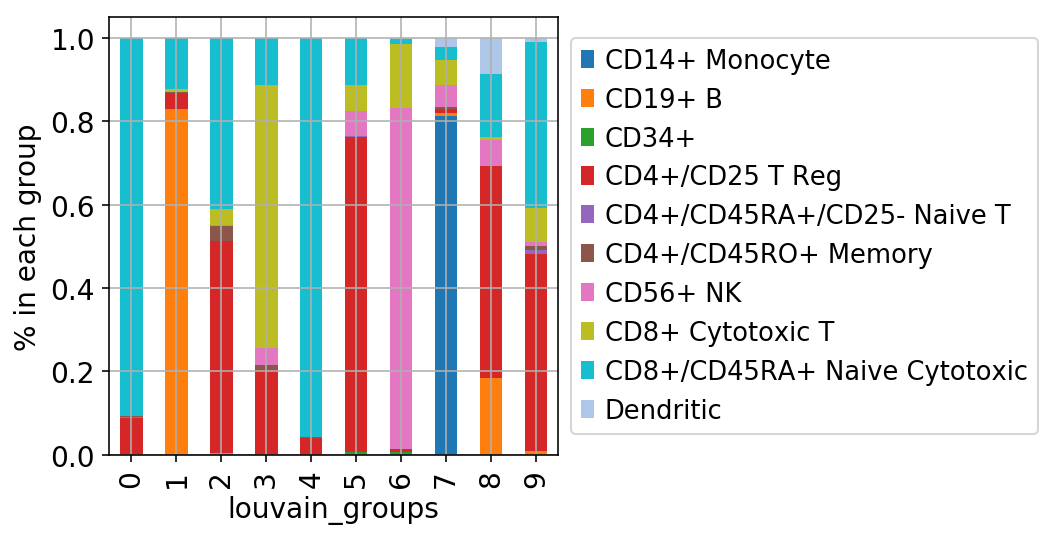

In [106]:
lv_stat_barplot(PBMC_data, rgroup='Classification_68K', cgroup='louvain_groups')

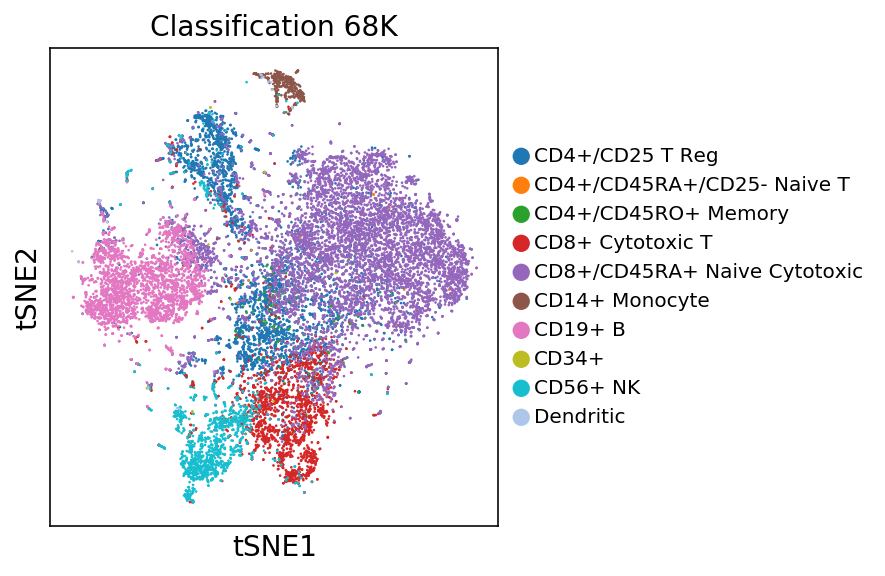

In [85]:
axs = sc.pl.tsne(PBMC_data, color='Classification_68K', legend_loc='right margin', legend_fontsize=10)

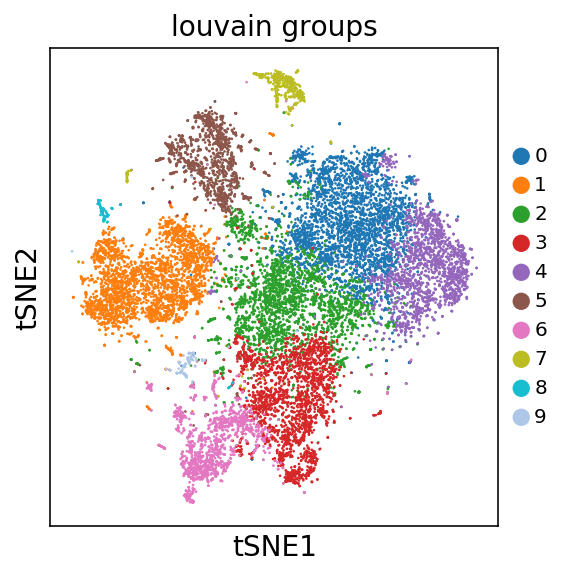

In [86]:
axs = sc.pl.tsne(PBMC_data, color='louvain_groups', legend_loc='right margin', legend_fontsize=10)

# write and read

## Write

In [84]:
sc.write('PBMC_data_BC_HVG', PBMC_data)